In [35]:
from __future__ import print_function, division

import gensim
import numpy as np
import pandas as pd
import sys, time, os, warnings, copy
from collections import Counter 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import itertools
from PIL import Image

warnings.filterwarnings("ignore")

import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn.manifold import TSNE
from skimage import io


# Load Data

In [36]:
## The location of the train images
dir_train_jpg = "./Data/Circle_Dataset/train/images/"
## The location of the test images
dir_test_jpg = "./Data/Circle_Dataset/test/images/"
## The location of the train caption file
dir_text_train = "./data/Circle_text/circle_annotations_train.txt"
## The location of the test caption file
dir_text_test = "./data/Circle_text/circle_annotations_test.txt"


print("The number of jpg files in train dataset: {}".format(len(os.listdir(dir_train_jpg))))
print("The number of jpg files in test dataset: {}".format(len(os.listdir(dir_test_jpg))))

The number of jpg files in train dataset: 2000
The number of jpg files in test dataset: 200


In [37]:
## read in the Flickr caption data
def annotations_reading(dir_text):
    file = open(dir_text,'r')
    text = file.read()
    file.close()


    datatxt = []
    for line in text.split('\n'):
        col = line.split('\t')
        if len(col) == 1:
            continue
        w = col[0].split("#")
        datatxt.append(w + [col[1].lower()])


    df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

    uni_filenames = np.unique(df_txt.filename.values)
    print("The number of unique file names : {}".format(len(uni_filenames)))
    print("The distribution of the number of captions for each image:")
    Counter(Counter(df_txt.filename.values).values())
    
    return df_txt, uni_filenames

# Sentence Processing 

In [38]:
def get_sentence_embedding(sentence, model):
    embeddings = np.array([model.word_vec(word) for word in sentence.split() if word in model.wv.vocab.keys()])
    if embeddings.ndim == 2:
        return np.sum(embeddings.T,axis=1)
    elif embeddings.ndim == 1:
        return embeddings

# Image Processing 

In [39]:
def load_image_model():
    image_model = models.resnet18(pretrained=True)

    device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for param in image_model.parameters():
        param.requires_grad = False
    image_model = image_model.to(device)
    return image_model

In [40]:
plt.ion()   # interactive mode

def get_datasets():
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = './Data/Circle_Dataset/'

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    return image_datasets


def classes_generation(dataset, image_datasets):
    
    if dataset == 'train':
        image_datasets[dataset].classes = uni_filenames_train
    elif dataset == 'test':
        image_datasets[dataset].classes = uni_filenames_test
        
    class_names = image_datasets[dataset].classes
  
    image_datasets[dataset].class_to_idx = {image_datasets[dataset].classes[i]: i for i in range(len(image_datasets[dataset].classes))}

    for i, (image, class_name) in enumerate(image_datasets[dataset].imgs):
        filename  = image_datasets[dataset].class_to_idx[image.replace('./Data/Circle_Dataset/'+dataset+'\\images\\','')]
        if dataset == 'train':
            image_datasets[dataset].imgs[i] = (image, list(df_txt_train[df_txt_train["filename"]==class_names[filename]]['caption'].values))
        elif dataset == 'test':
            image_datasets[dataset].imgs[i] = (image, list(df_txt_test[df_txt_test["filename"]==class_names[filename]]['caption'].values))
    
    return image_datasets

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [42]:
tmp_images = []

def generate_representations(dataset):
    if dataset == 'train':
        images= torch.zeros([df_txt_train.shape[0], 1000], dtype=torch.float)
        captions = torch.zeros([df_txt_train.shape[0], 300], dtype=torch.float)
    elif dataset == 'test':
        images= torch.zeros([df_txt_test.shape[0], 1000], dtype=torch.float)
        captions = torch.zeros([df_txt_test.shape[0], 300], dtype=torch.float)
        
    for i, (image, labels) in enumerate(tqdm(dataloaders[dataset])):
        
        ########### TMP
        tmp_images.append(image)
        
        labels = [x[0] for x in labels]
        im = image_model(image)
        for j in range(len(labels)):
            capt = get_sentence_embedding(labels[j], text_model)
            if capt.size == 300:
                # a modifier pour ne pas sauvegarder 5x la meme image
                images[i+j] = im
                #captions += np.random.random()
                captions[i+j] = torch.from_numpy(capt)
    return images, captions


# Sparse Autoencoder


In [43]:
class SparseAutoencoder(nn.Module):
    def __init__(self, n_inp, n_hidden):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(n_inp, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_inp)

    def forward(self, x):
        encoded = F.relu(self.encoder(x)) # relu or sigmoid
        decoded = F.sigmoid(self.decoder(encoded))
        return encoded, decoded

In [44]:
def kl_divergence(p, q):
    '''
    args:
        2 tensors `p` and `q`
    returns:
        kl divergence between the softmax of `p` and `q`
    '''
    p = F.softmax(p)
    q = F.softmax(q)

    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))

    return s1 + s2

In [45]:
def l1_penalty(var):
    return torch.abs(var).sum()

In [46]:
def normalize(dataset):
    '''Normalization between 0 and 1'''
    
    min_list = []
    max_list = []
    
    for i in range(dataset.shape[1]):
        column = dataset[:,i]
        local_min = torch.min(column)
        local_max = torch.max(column)
    
        dataset[:,i] = (column - local_min)/(local_max - local_min)
        min_list.append(local_min)
        max_list.append(local_max)
        
    return dataset, min_list, max_list

def normalize_sample(sample, min_list, max_list):
    
    
    # [0,:][None,:] is shape is [...]
    
    for i in range(sample.shape[1]):
        column = sample[:,i]
        local_min = min_list[i]
        local_max = max_list[i]
    
        sample[:,i] = (column - local_min)/(local_max - local_min)

    
    return sample


In [47]:
def train(n_hidden, l1, dataset):
    
    auto_encoder = SparseAutoencoder(N_INP, n_hidden)
    optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE)
    


    for epoch in range(N_EPOCHS):

        encoded, decoded = auto_encoder(dataset)

        mse_loss = F.mse_loss(decoded, dataset)

        rho_hat = torch.sum(encoded, dim=0, keepdim=True)

        if use_kl:
            sparsity_penalty = BETA * kl_divergence(rho, rho_hat)
            loss = mse_loss + sparsity_penalty
        else:
            l1_reg = l1 * l1_penalty(auto_encoder.encoder.weight)
            loss = mse_loss + l1_reg

        optimizer.zero_grad() # Clears the gradient
        loss.backward() # Computes gradient
        optimizer.step() # Update rule
        #if epoch%10 == 0:
            #print("Epoch: [%3d], Loss: %.4f" %(epoch + 1, loss.data))
            #print("Reconstruction mean squared error : ", mse_loss)
            #print("Average sparsity : ",  rho_hat.sum()/N_HIDDEN)
        
        if epoch==N_EPOCHS-1:
            print("Final MSE : ", mse_loss)
            #x_embedded = TSNE(n_components=2).fit_transform(encoded.detach().numpy())
            #plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
            #plt.show()
        
    hist = torch.histc(auto_encoder.encoder.weight)
    inf = torch.min(auto_encoder.encoder.weight.detach())
    sup = torch.max(auto_encoder.encoder.weight.detach())
    print("n_hidden : {0}, l1_reg : {1}".format(n_hidden, l1))
    plt.xlabel('Weight values')
    plt.ylabel('Counts')
    plt.plot(list(np.linspace(inf, sup, 100)), hist.detach().numpy())
    plt.show()
    return auto_encoder

# Autoassociative memory - Hopfield Network - BCPNN

# Discrete approach

In [48]:
def get_encoded_values(dataset):
    encoded, _ = auto_encoder(dataset)
    encoded = encoded.detach().numpy()
    return encoded

# Discretize the input : 1 hypercolumn per element with same number of units in each hypercolumn
# Same number of intervals for the continuous elements

nb_intervals = 4

# Do better by looking at the distribution inside the dataset

def discretize(x, percentiles, nb_intervals):
    nb_intervals = percentiles.shape[0] - 1
    nb_samples = x.shape[0]
    discrete_x = np.zeros((nb_samples, nb_intervals*x.shape[1])) # one line is one hypercolumn
    
    for j in range(x.shape[1]):
        for i, e in enumerate(x[:, j]):
            if(e < percentiles[0, j]):
                discrete_x[i, j*nb_intervals] = 1
            elif(e >= percentiles[-1, j]):
                discrete_x[i, j*nb_intervals + nb_intervals-1] = 1
            else:
                for k in range(1, percentiles.shape[0]):
                    if e >= percentiles[k-1, j] and e < percentiles[k, j]:
                        discrete_x[i, j*nb_intervals + k-1] = 1
                        break

    return discrete_x

def calculate_weights(learning_samples, hypercolumn_size):
    # BCPNN without hypercolumns
    # learning_samples are discrete
    
    nb_samples = learning_samples.shape[0]
    activation_probabilities = np.sum(learning_samples, axis=0)/nb_samples # Only if patterns are only made of 0 and 1
    coactivation_probabilities = (np.transpose(learning_samples) @ learning_samples) / nb_samples
    
    w = np.zeros((learning_samples.shape[1], learning_samples.shape[1]))
    
    for i in tqdm(range(w.shape[0])):
        for j in range(w.shape[1]):
            if i//hypercolumn_size == j//hypercolumn_size:
                w[i, j] = 0
            elif activation_probabilities[i] == 0 or activation_probabilities[j] == 0:
                w[i, j] = 0 # Useless
            elif coactivation_probabilities[i, j] == 0:
                w[i, j] = 1/nb_samples 
            else:
                w[i, j] = coactivation_probabilities[i, j]/(activation_probabilities[i]*activation_probabilities[j]) 
             
    bias = np.where(activation_probabilities == 0, 1/(nb_samples**2), activation_probabilities)
    
    return w, bias

def softmax(x, temperature = 1):
    return np.exp(x/temperature)/np.expand_dims(np.sum(np.exp(x/temperature), axis = 1), axis = 1)

def recall(x, epsilon = 250):
    nb_intervals = percentiles.shape[0] - 1
    
    x_prev = np.random.random(x.shape)
    while(np.linalg.norm(x - x_prev) > epsilon):
        print(np.linalg.norm(x - x_prev), epsilon)
        x_prev = x 
        x = np.dot(x, w) + bias
        for j in range(0,x.shape[1], nb_intervals):         
            x[:, j:j+nb_intervals] = softmax(x[:, j:j+nb_intervals] - np.expand_dims(np.amax(x[:, j:j+nb_intervals], axis=1), axis = 1), temperature = 1)
          
    return x 

In [49]:
def get_sample_representation(image, label, image_model, text_model, percentiles, return_encoded = False):
    
    """image_path = dir_train_jpg  + image_name 

    index = df_txt_train[df_txt_train['filename'] == image_name]['caption'].index[0]
    label = df_txt_train[df_txt_train['filename'] == image_name]['caption'][index]
    
    im = Image.open(image_path)
    im = np.array( im, dtype='float32' )
    im = np.expand_dims(im, axis = 0)
    im = np.swapaxes(im,3,2)
    im = np.swapaxes(im,2,1)
    im = torch.from_numpy(im)"""
    
    label = label[0]
    im = image_model(image)    
    capt = get_sentence_embedding(label, text_model)      
    capt = torch.from_numpy(np.expand_dims(capt,axis = 0))
    
    # Get autoencoder's hidden representations
    
    
    ###TO MODIFY to use whole dataset
    encoded = get_encoded_values(im, capt)
    
    if(return_encoded == True):
        return torch.cat((im, capt), 1)
    
    # get percentiles
    nb_intervals = 4

    discrete_encoded = discretize(encoded, percentiles, nb_intervals)

    # get recall
    x = recall(discrete_encoded)

    return x

# Read and generate representations

In [50]:
# read annotation files
df_txt_train, uni_filenames_train = annotations_reading(dir_text_train)
df_txt_test, uni_filenames_test = annotations_reading(dir_text_test)

# load text model
text_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-SLIM.bin', binary=True)  

# load image model
image_model = load_image_model()

# load datasets
image_datasets = get_datasets()


# create dataloaders
image_datasets = classes_generation('train', image_datasets)
image_datasets = classes_generation('test', image_datasets)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# generate representations 
images_train, captions_train = generate_representations('train')
images_test, captions_test = generate_representations('test')

# concatenate and normalize data
dataset, min_list, max_list = normalize(torch.cat((images_train, captions_train), 1))


The number of unique file names : 2000
The distribution of the number of captions for each image:
The number of unique file names : 200
The distribution of the number of captions for each image:


# Train autoencoder 

Final MSE :  tensor(0.0172, grad_fn=<MseLossBackward>)
n_hidden : 2000, l1_reg : 1e-05


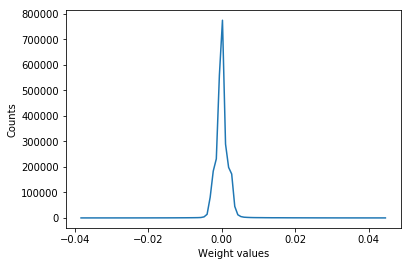

In [51]:
#                Autoencoder parameters                     #
#############################################################
# Model parameters
# BATCH_SIZE = 5 a intégrer
N_INP = 1000 + 300 # Image representation + Word2Vec
N_HIDDEN = 2000
N_EPOCHS = 30
LEARNING_RATE = 1e-3

use_kl = False

# If using KL-divergence
BETA = 3 # Importance of the KL-divergence penalty term
RHO = 0.01 # Target sparsity

if use_kl :
    rho = torch.FloatTensor([RHO for _ in range(N_HIDDEN)]).unsqueeze(0)

# If using L1 regularization
LAMBDA = 1e-5 # L1 penalty term
#############################################################

# define autoencoder
auto_encoder = SparseAutoencoder(N_INP, N_HIDDEN)
optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE)
auto_encoder = train(n_hidden=N_HIDDEN, l1=LAMBDA, dataset = dataset)

# Testing 

In [52]:
#                         Testing                           #
#############################################################

# test for different values


"""x_embedded = TSNE(n_components=2).fit_transform(captions_train.numpy())
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

x_embedded = TSNE(n_components=2).fit_transform(dataset.numpy())
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

for n_hidden, l1 in itertools.product([100,1300,3000],[0,1e-5]):
    train(n_hidden, l1, dataset)

hist = torch.histc(auto_encoder.encoder.weight)
inf = torch.min(auto_encoder.encoder.weight.detach())
print(inf)
sup = torch.max(auto_encoder.encoder.weight.detach())
print(sup)
print(hist.detach().numpy())
plt.plot(list(np.linspace(inf, sup, 100)), hist.detach().numpy())

# Test

images_test = normalize(images_test) # Ou mieux de normaliser dataset après concaténation ??????
captions_test = normalize(captions_test)

dataset_test = torch.cat((images_test, captions_test), 1)


encoded_test, decoded_test = auto_encoder(dataset_test)
mse_loss_test = F.mse_loss(decoded_test, dataset_test)

i=0
for e in encoded_test[0]:
    if e > 1e-3:
        i+=1
print(i, "elements different from 0")
print("Reconstruction mean squared error on test : ", mse_loss_test)
print(dataset_test[0])
print(decoded_test[0])
print(torch.abs(dataset_test-decoded_test))
print(torch.sum(torch.abs(dataset_test-decoded_test)))
# divide by norm for percentage
print(encoded_test.shape)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
classes = [x[0] for x in classes]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=classes)"""

'x_embedded = TSNE(n_components=2).fit_transform(captions_train.numpy())\nplt.scatter(x_embedded[:, 0], x_embedded[:, 1])\nplt.show()\n\nx_embedded = TSNE(n_components=2).fit_transform(dataset.numpy())\nplt.scatter(x_embedded[:, 0], x_embedded[:, 1])\nplt.show()\n\nfor n_hidden, l1 in itertools.product([100,1300,3000],[0,1e-5]):\n    train(n_hidden, l1, dataset)\n\nhist = torch.histc(auto_encoder.encoder.weight)\ninf = torch.min(auto_encoder.encoder.weight.detach())\nprint(inf)\nsup = torch.max(auto_encoder.encoder.weight.detach())\nprint(sup)\nprint(hist.detach().numpy())\nplt.plot(list(np.linspace(inf, sup, 100)), hist.detach().numpy())\n\n# Test\n\nimages_test = normalize(images_test) # Ou mieux de normaliser dataset après concaténation ??????\ncaptions_test = normalize(captions_test)\n\ndataset_test = torch.cat((images_test, captions_test), 1)\n\n\nencoded_test, decoded_test = auto_encoder(dataset_test)\nmse_loss_test = F.mse_loss(decoded_test, dataset_test)\n\ni=0\nfor e in encode

In [53]:
# Get autoencoder's hidden representations
encoded = get_encoded_values(dataset)

"""# get embedding
x_embedded = TSNE(n_components=2).fit_transform(encoded)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()"""


# get percentiles
nb_intervals = 4
percentiles = np.percentile(encoded, np.linspace(0, 100, nb_intervals+1), axis=0)

discrete_encoded = discretize(encoded, percentiles, nb_intervals)


"""# get embedding
x_embedded = TSNE(n_components=2).fit_transform(discrete_encoded)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()"""

# calculate weights
w, bias = calculate_weights(discrete_encoded, encoded.shape[1])

"""# Test on test set
x = discretize(encoded_test.detach().numpy(), percentiles, nb_intervals)"""

"""# get recall
output = recall(discrete_encoded)"""

# get embedding
"""x_embedded = TSNE(n_components=2).fit_transform(output)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()"""

'x_embedded = TSNE(n_components=2).fit_transform(output)\nplt.scatter(x_embedded[:, 0], x_embedded[:, 1])\nplt.show()'

In [54]:
# get recall
output = recall(discrete_encoded)

2309.752029561219 250
1075.027977507867 250
325.66047131442133 250


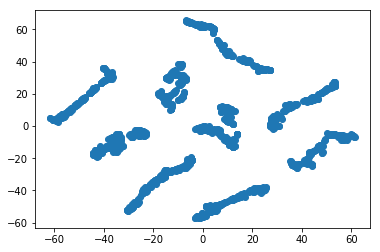

In [55]:
x_embedded = TSNE(n_components=2).fit_transform(output)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

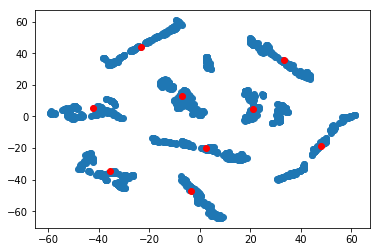

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([212, 239, 242, 229, 225, 219, 208, 218, 208], dtype=int64))


"plt.scatter(encoded[:2000, 0], encoded[:2000, 1],s = 1 )\nplt.scatter(x_embedded[2000:, 0], x_embedded[2000:, 1], c='red', s=10)\n\nfrom pylab import *\ncmap = cm.get_cmap('inferno', 9)\n\ny_kmeans = k_means.predict(x)\nplt.figure(figsize=(15,15))\nplt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_kmeans, s=30, cmap=cmap)\n"

In [56]:
from sklearn import cluster

n_clusters = 9


k_means = cluster.KMeans(n_clusters=n_clusters, n_init=10)
k_means.fit(output)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

x_embedded = TSNE(n_components=2).fit_transform(np.vstack([output, values]))
plt.scatter(x_embedded[:2000, 0], x_embedded[:2000, 1], )
plt.scatter(x_embedded[2000:, 0], x_embedded[2000:, 1], c='red')
plt.show()

print(np.unique(k_means.predict(output), return_counts = True))

"""plt.scatter(encoded[:2000, 0], encoded[:2000, 1],s = 1 )
plt.scatter(x_embedded[2000:, 0], x_embedded[2000:, 1], c='red', s=10)

from pylab import *
cmap = cm.get_cmap('inferno', 9)

y_kmeans = k_means.predict(x)
plt.figure(figsize=(15,15))
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_kmeans, s=30, cmap=cmap)
"""

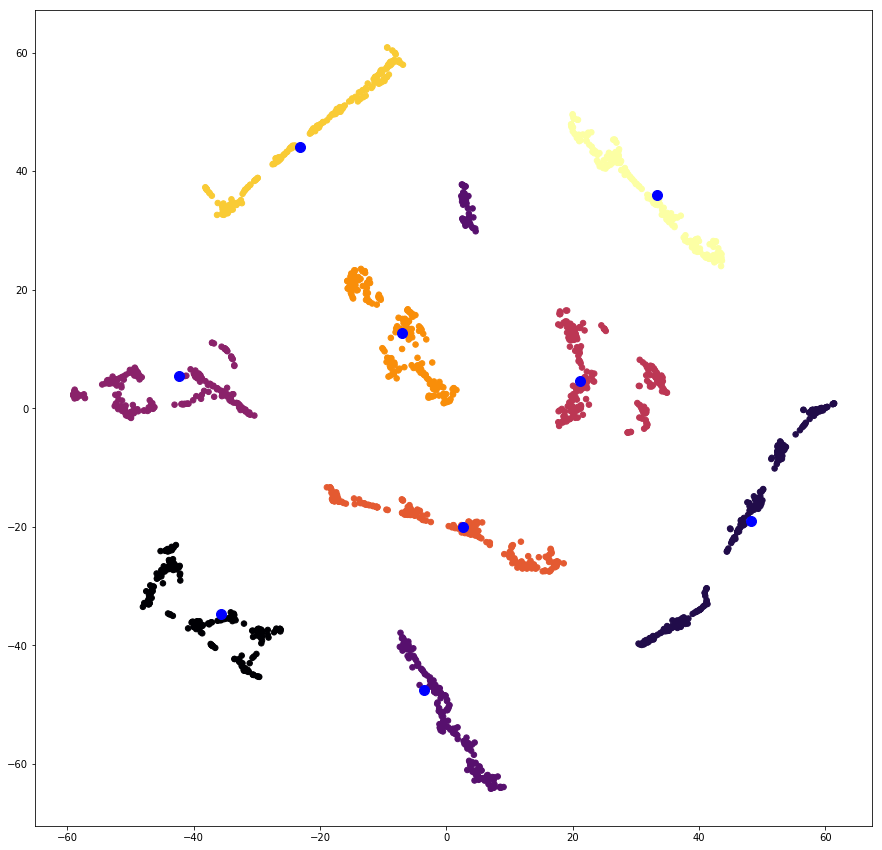

In [57]:
from pylab import *
cmap = cm.get_cmap('inferno', 9)

y_kmeans = k_means.predict(output)
plt.figure(figsize=(15,15))
plt.scatter(x_embedded[:2000, 0], x_embedded[:2000, 1], c=y_kmeans, s=30, cmap=cmap)
plt.scatter(x_embedded[2000:, 0], x_embedded[2000:, 1], c='blue', s=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


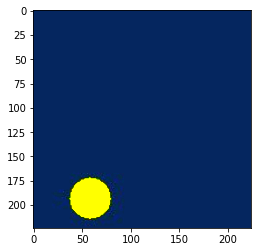

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


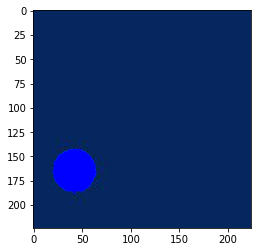

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


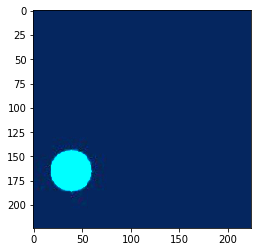

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


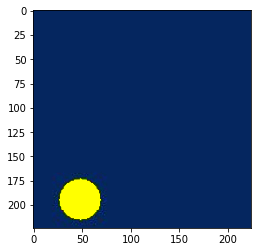

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


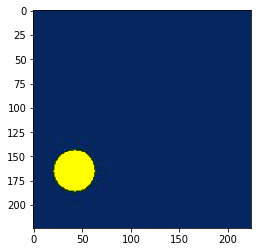

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


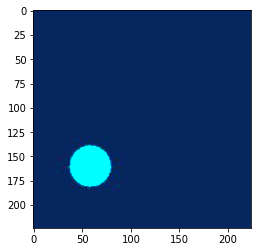

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


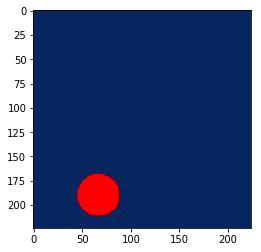

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


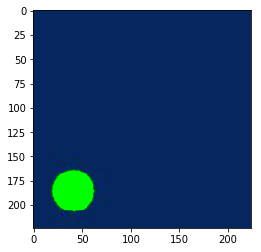

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


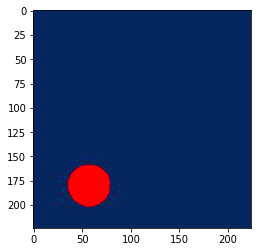

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


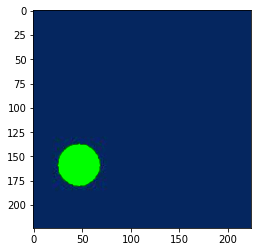

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


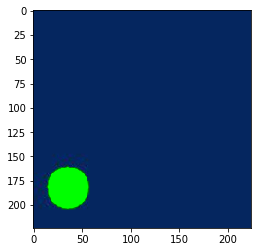

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


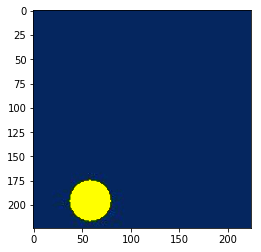

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


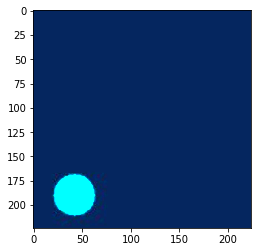

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


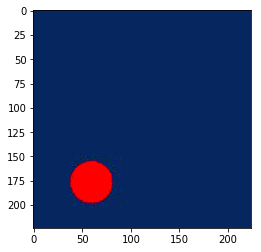

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


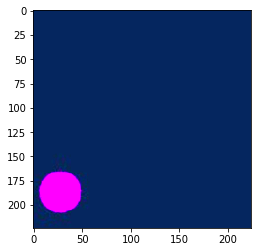

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


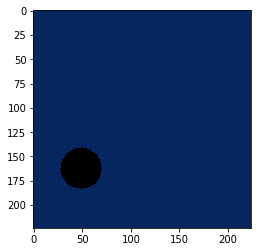

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


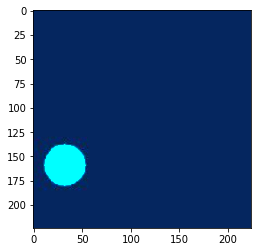

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


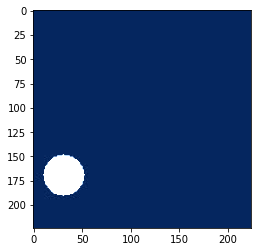

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


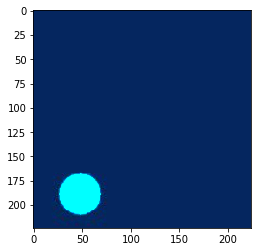

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


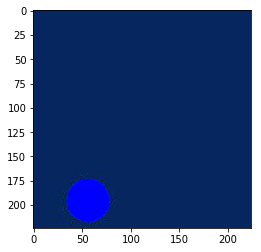

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


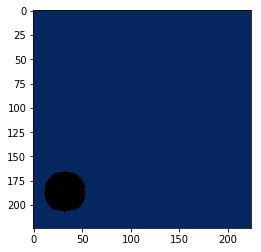

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


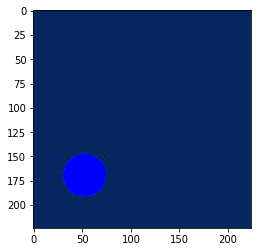

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


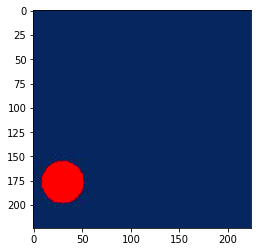

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


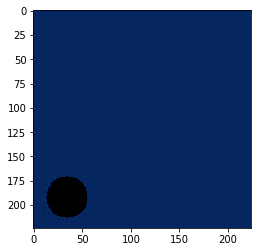

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


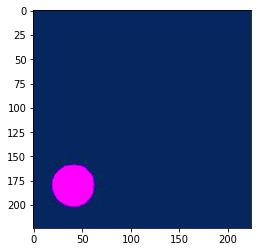

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


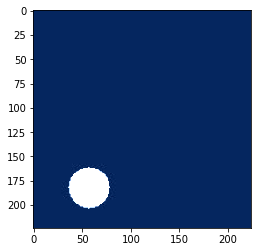

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


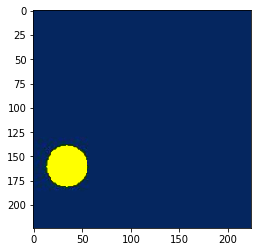

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


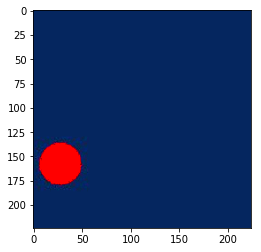

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


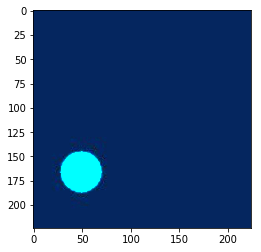

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


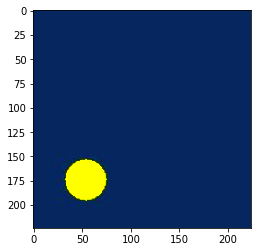

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


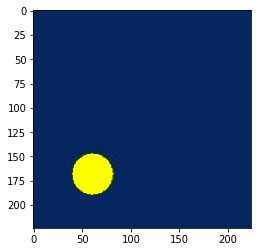

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


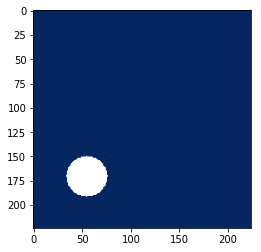

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


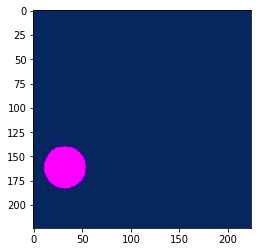

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


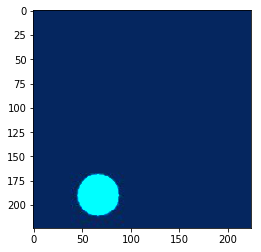

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


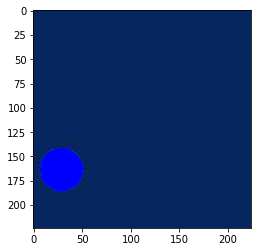

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


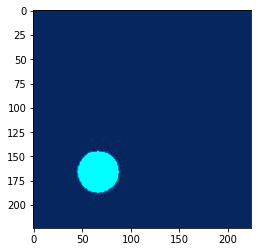

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


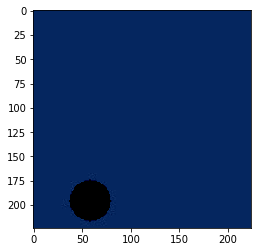

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


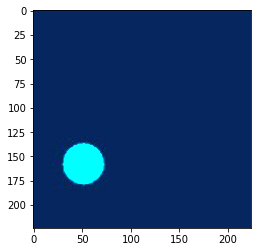

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


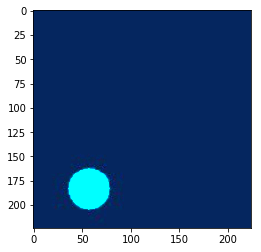

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


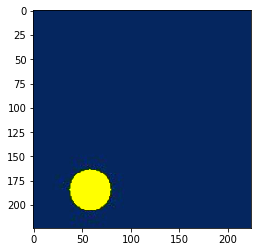

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


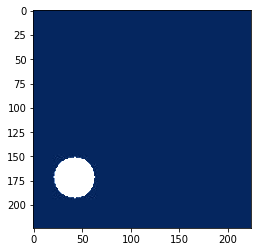

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


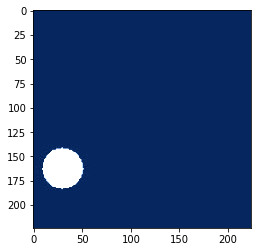

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


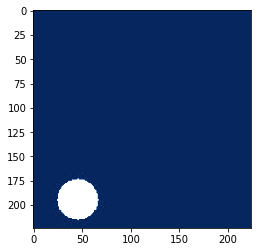

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


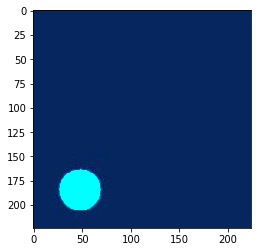

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


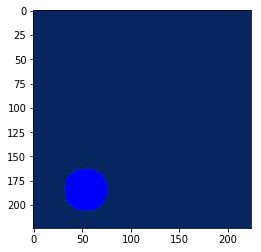

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


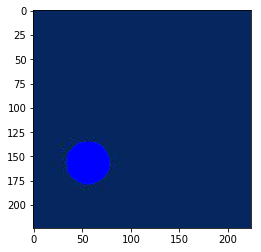

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


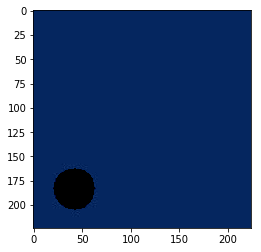

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


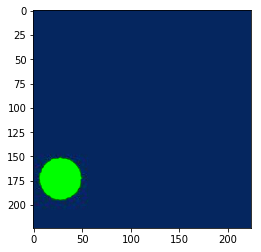

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


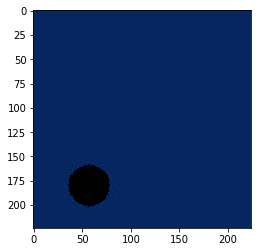

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


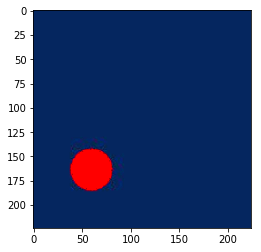

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


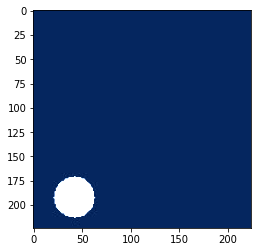

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


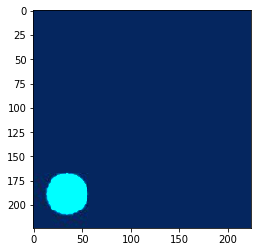

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


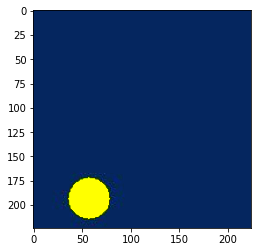

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


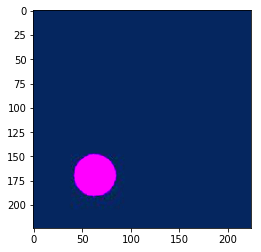

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


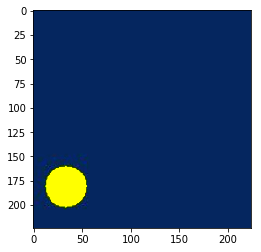

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


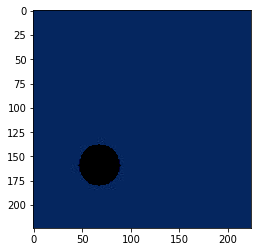

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


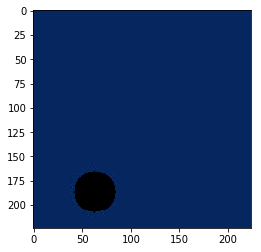

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


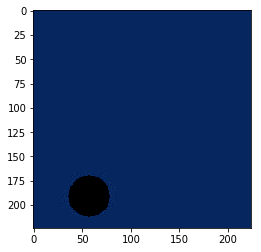

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


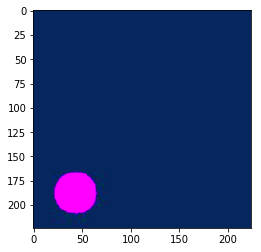

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


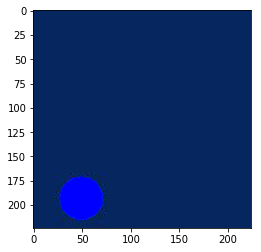

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


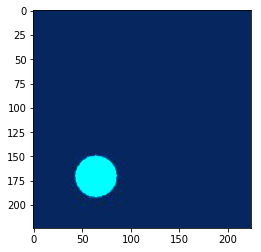

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


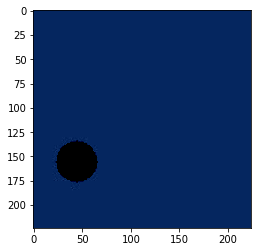

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


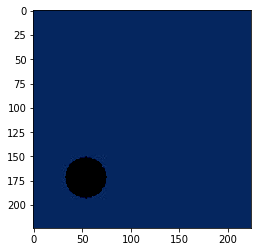

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


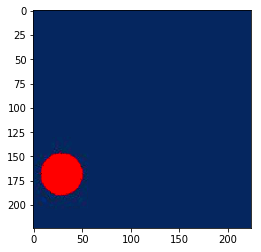

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


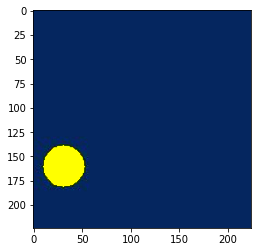

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


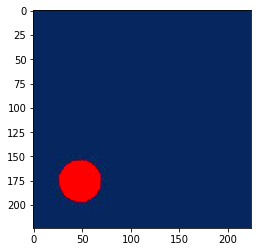

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


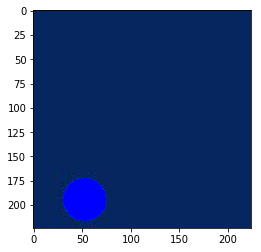

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


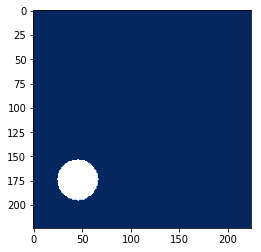

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


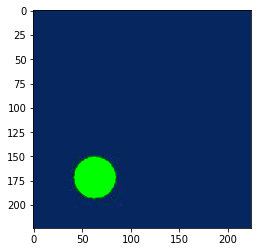

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


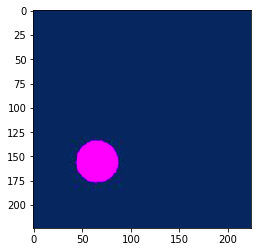

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


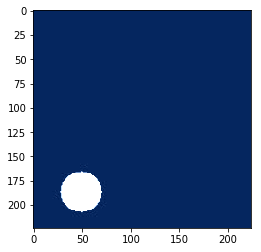

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


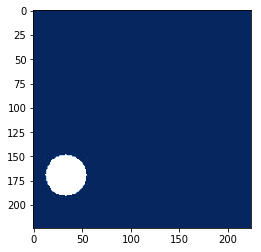

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


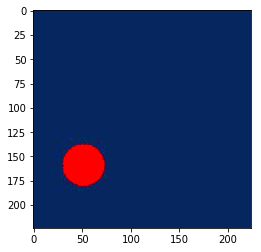

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


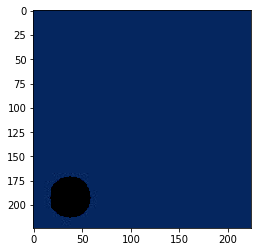

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


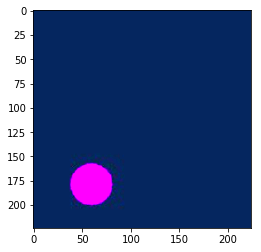

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


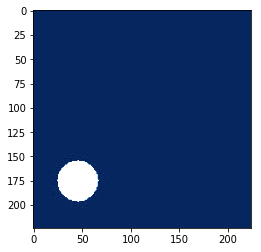

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


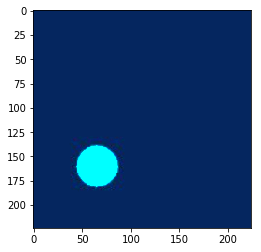

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


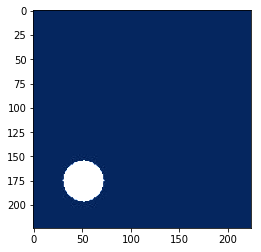

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


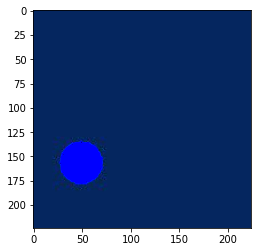

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


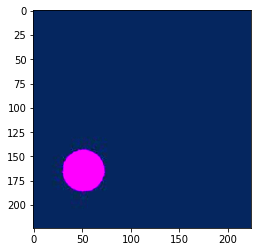

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


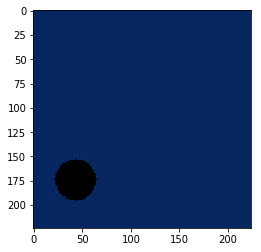

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


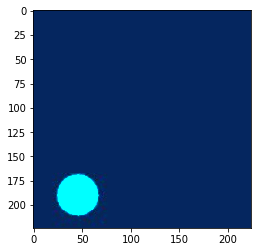

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


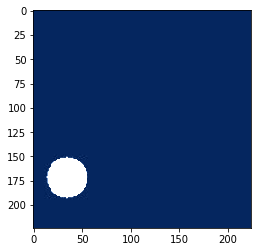

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


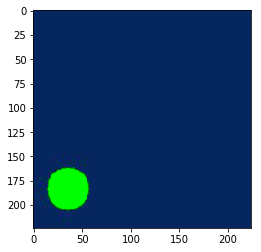

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


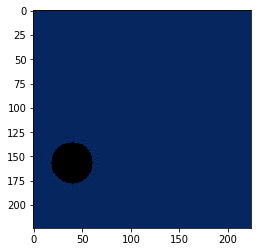

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


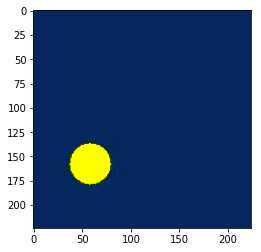

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


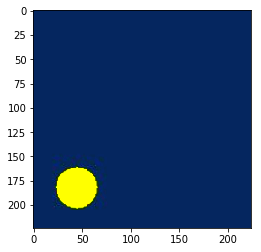

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


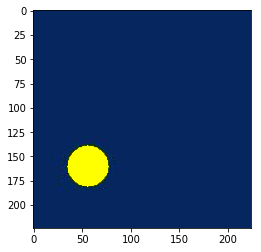

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


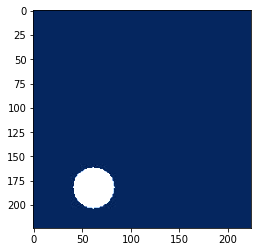

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


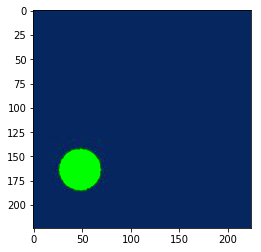

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


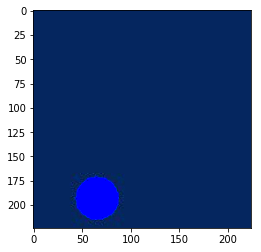

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


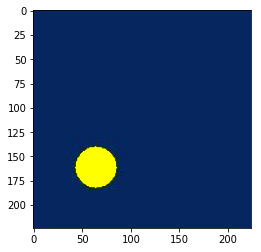

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


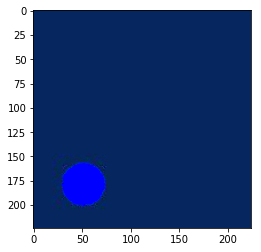

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


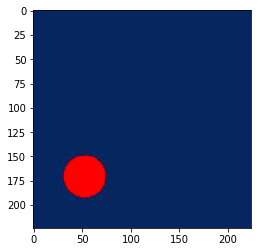

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


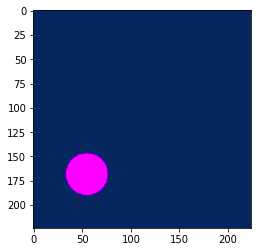

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


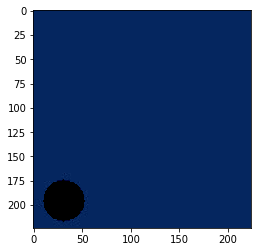

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


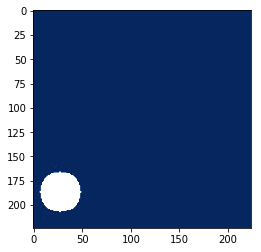

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


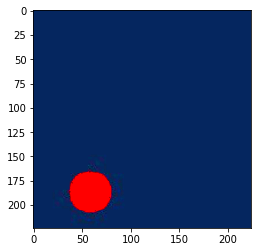

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


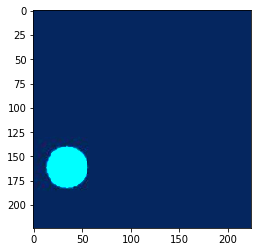

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


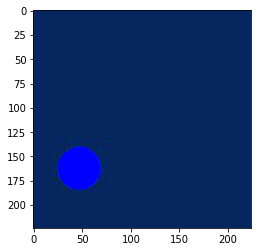

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


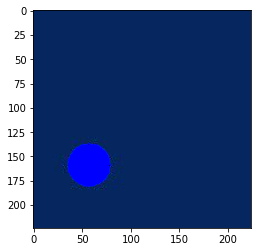

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


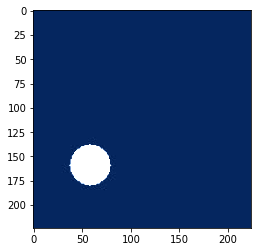

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


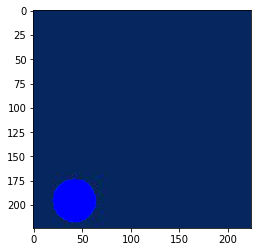

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


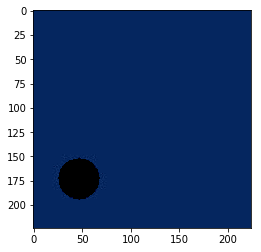

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


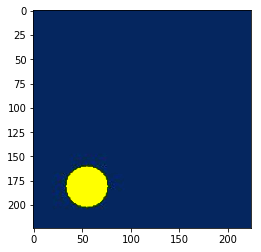

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


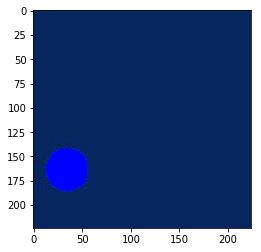

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


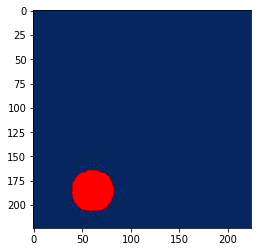

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


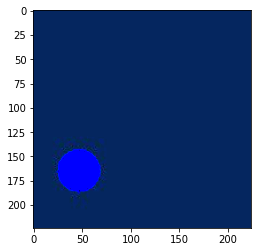

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


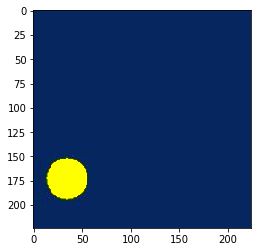

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


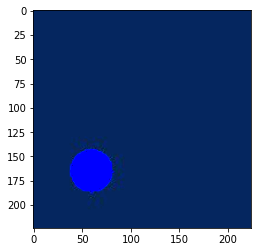

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


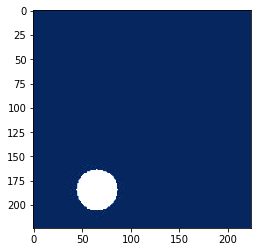

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


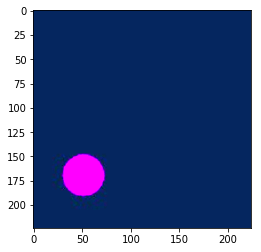

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


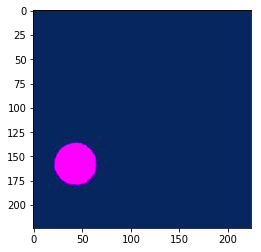

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


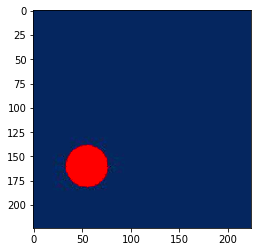

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


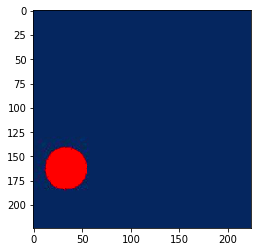

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


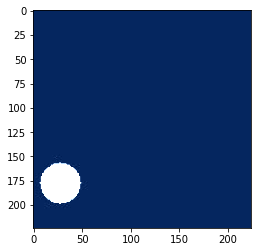

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


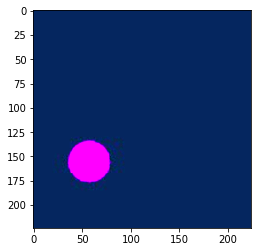

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


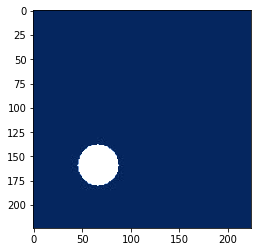

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


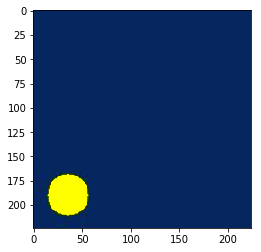

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


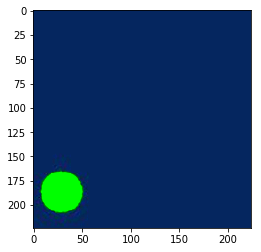

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


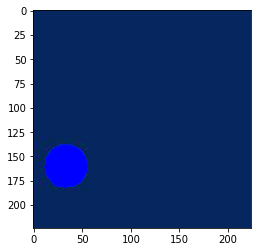

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


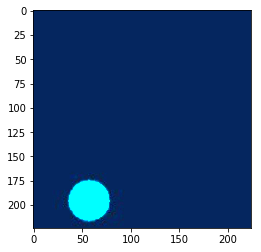

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


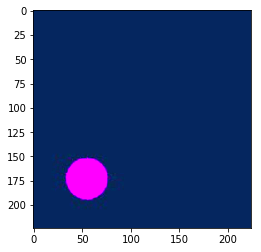

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


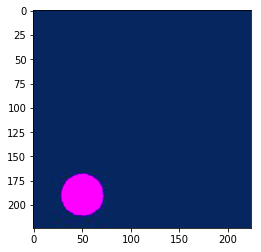

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


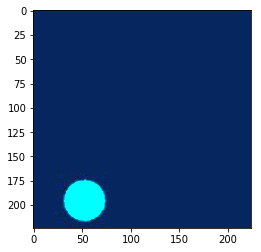

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


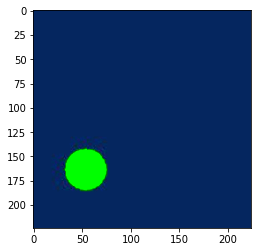

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


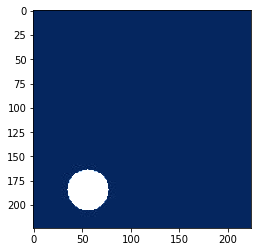

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


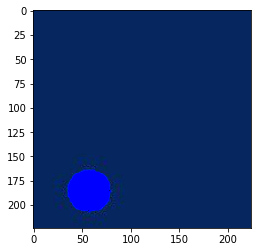

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


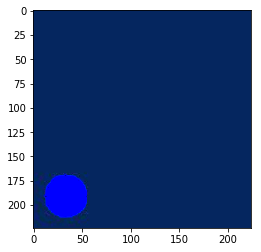

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


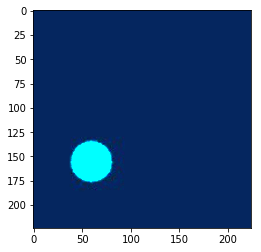

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


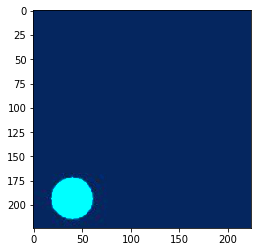

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


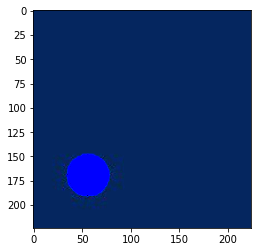

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


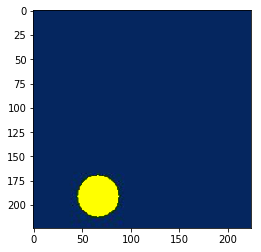

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


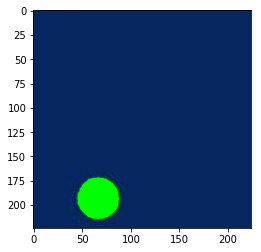

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


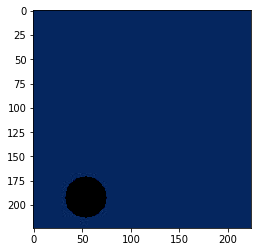

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


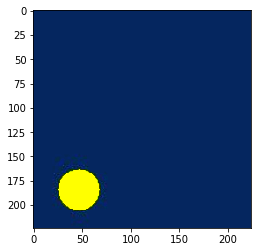

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


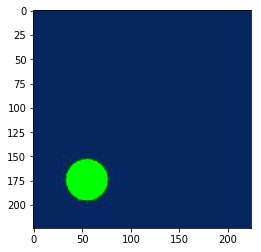

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


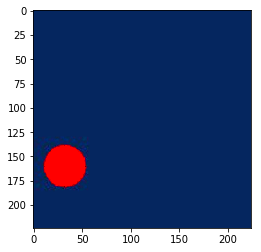

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


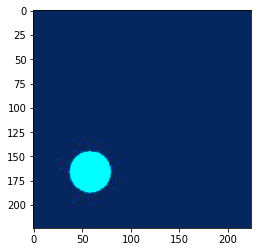

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


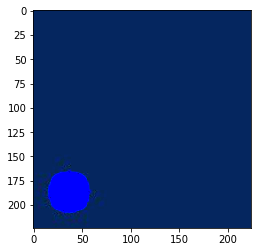

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


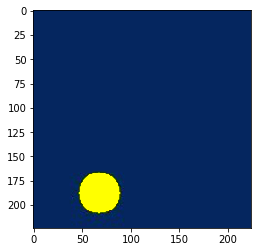

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


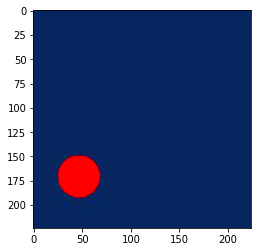

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


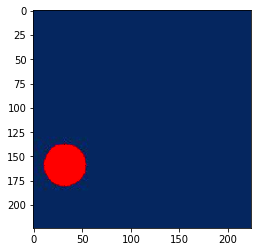

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


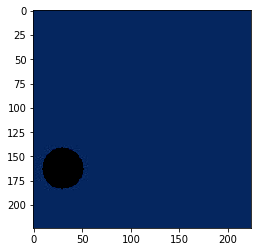

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


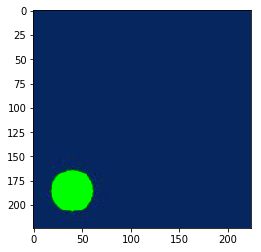

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


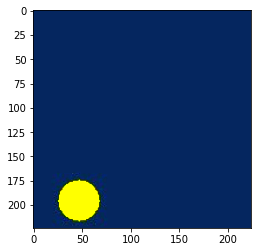

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


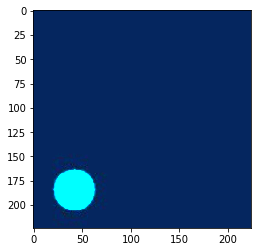

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


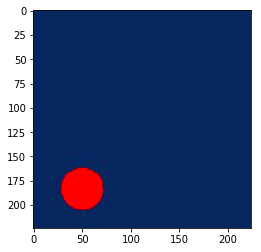

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


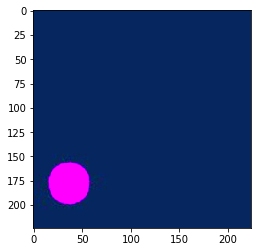

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


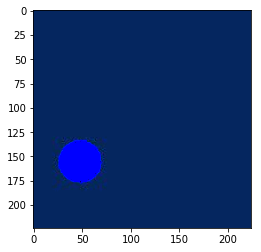

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


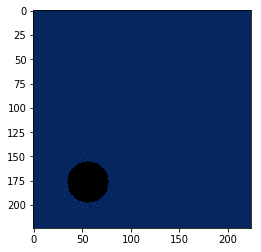

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


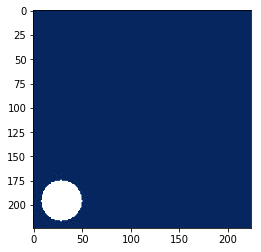

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


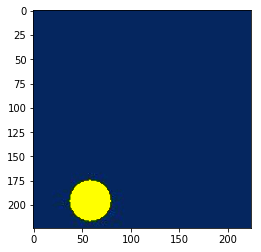

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


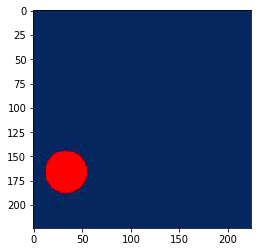

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


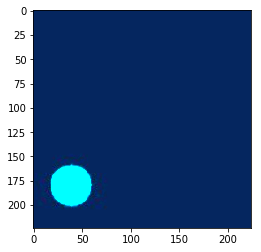

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


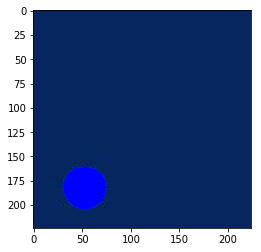

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


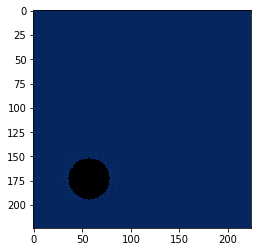

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


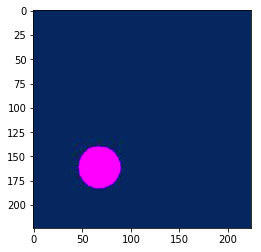

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


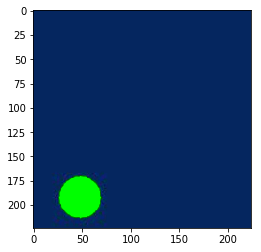

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


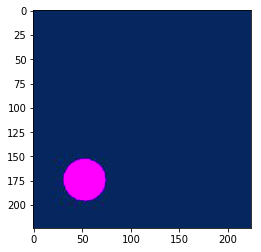

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


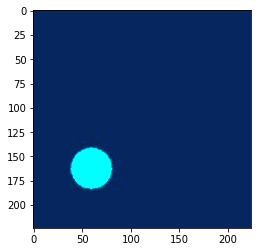

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


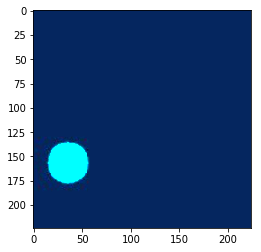

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


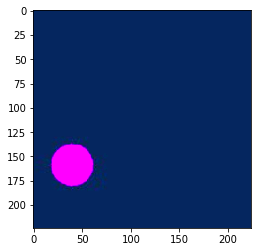

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


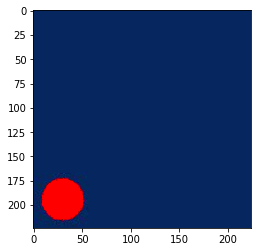

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


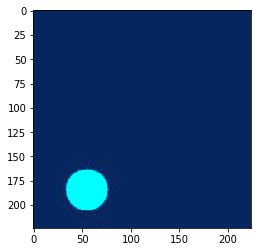

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


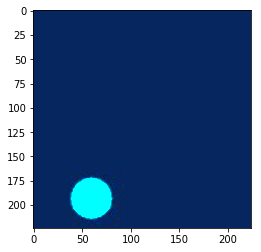

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


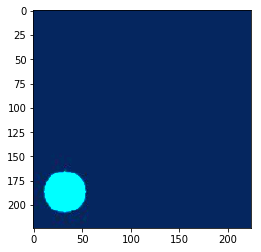

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


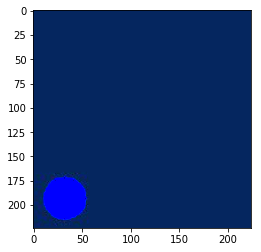

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


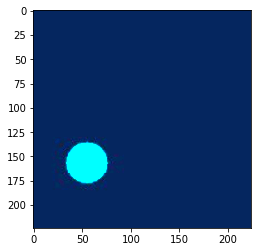

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


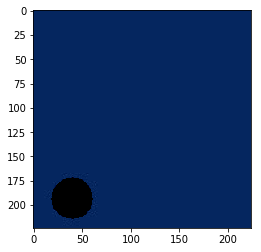

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


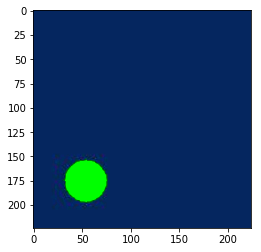

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


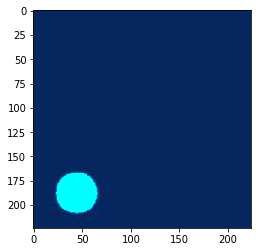

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


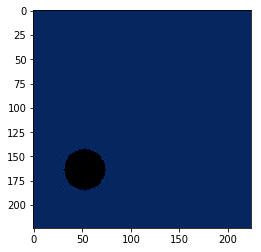

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


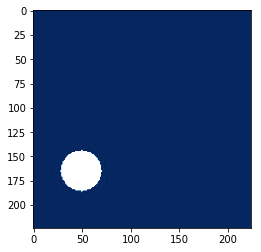

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


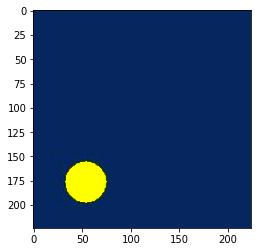

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


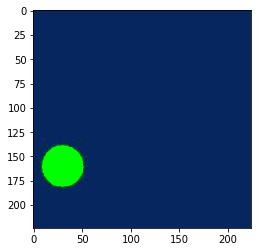

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


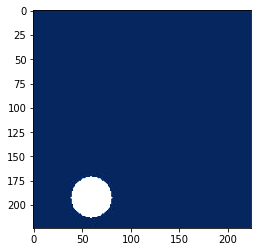

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


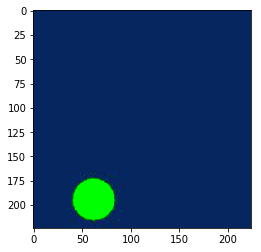

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


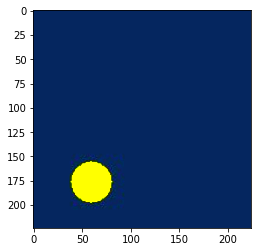

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


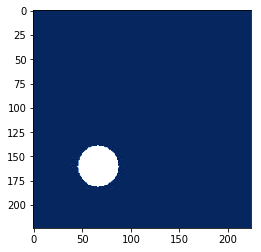

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


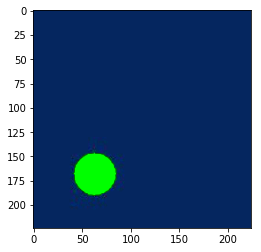

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


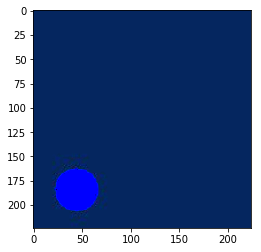

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


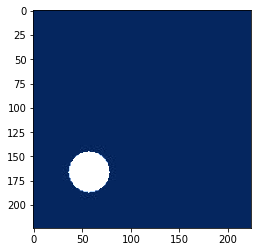

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


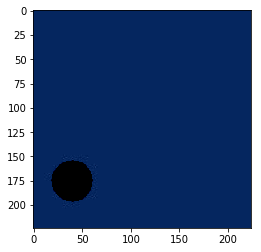

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


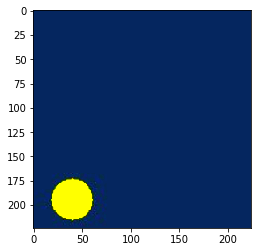

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


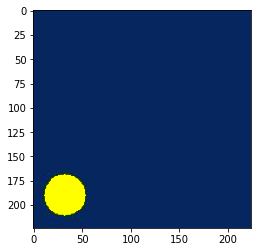

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


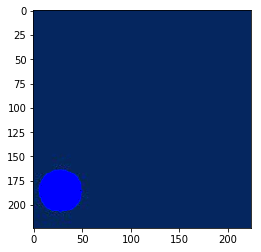

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


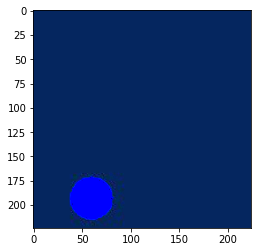

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


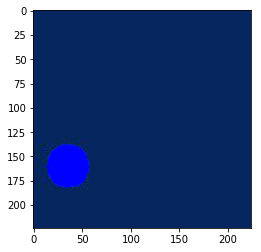

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


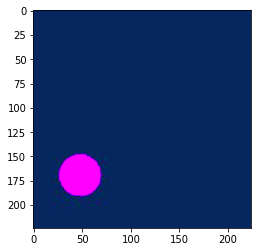

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


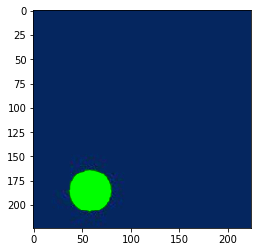

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


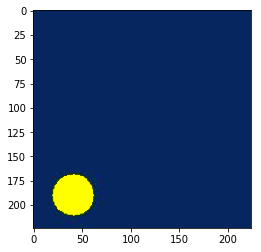

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


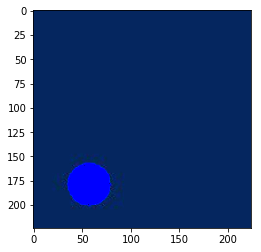

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


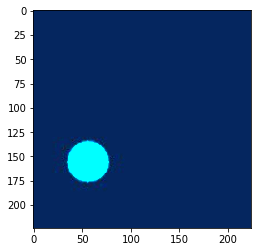

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


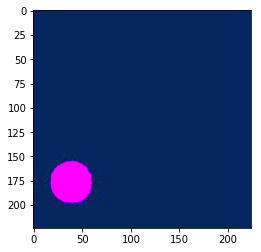

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


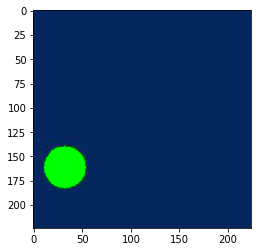

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


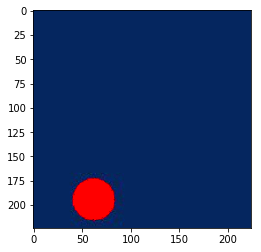

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


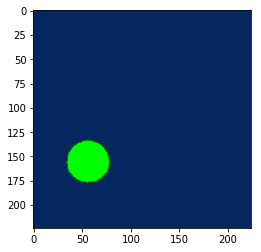

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


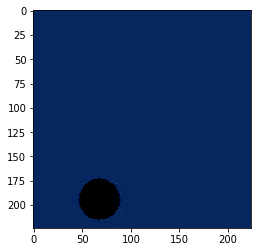

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


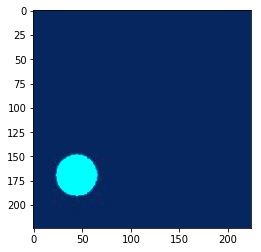

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


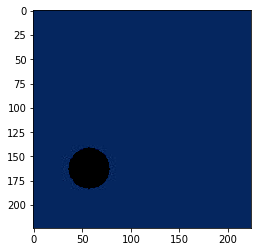

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


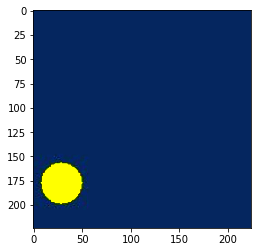

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


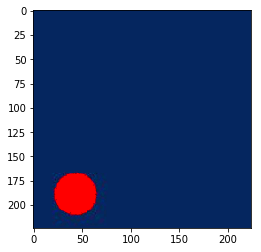

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


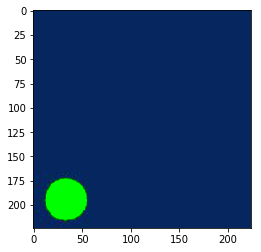

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


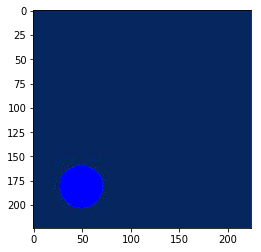

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


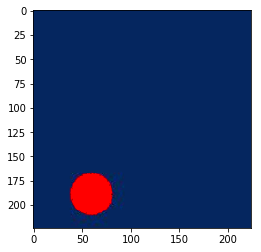

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


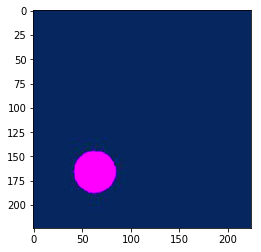

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


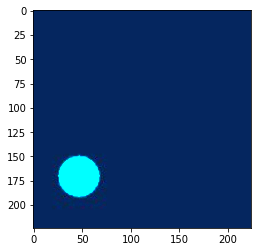

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


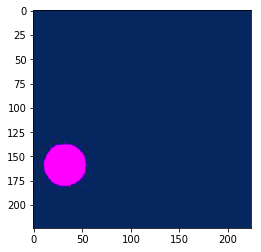

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


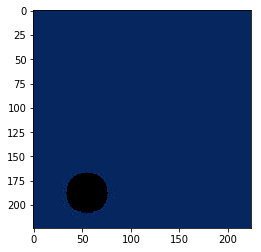

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


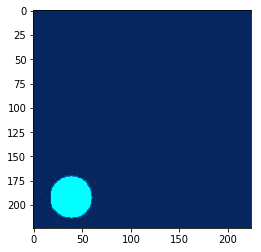

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


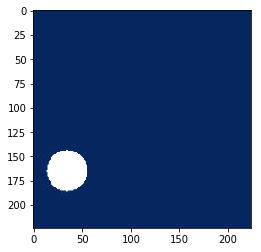

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


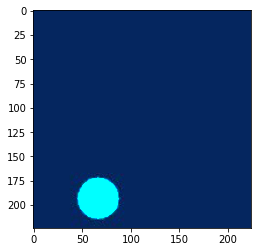

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


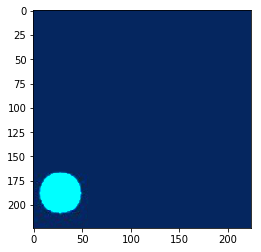

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


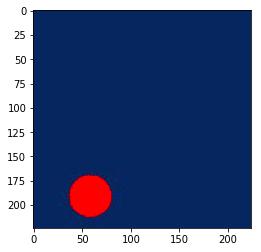

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


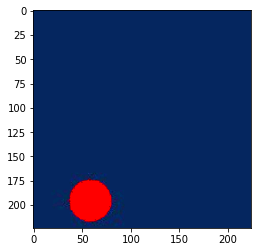

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


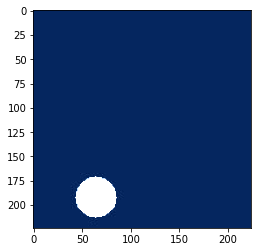

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


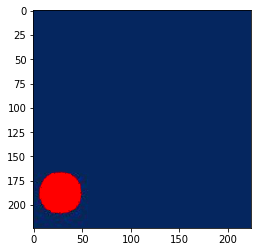

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


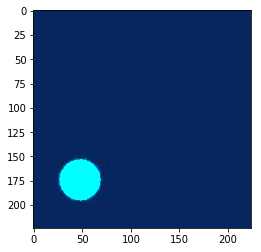

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


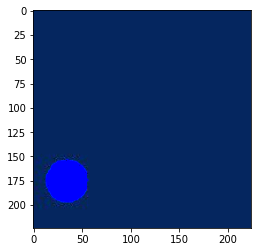

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


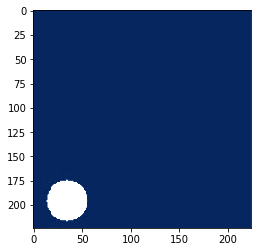

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


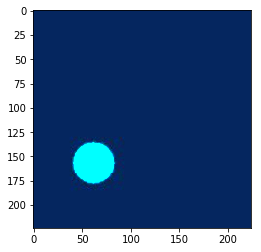

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


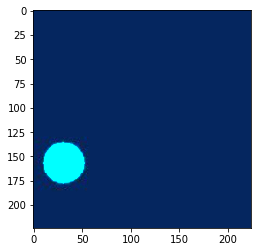

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


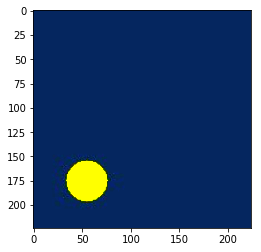

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


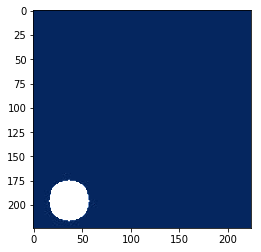

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


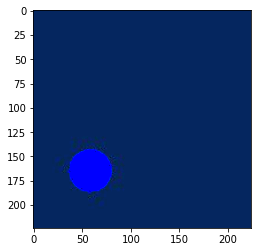

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


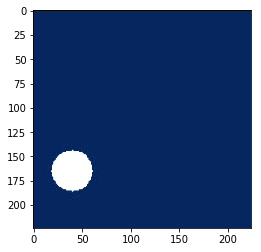

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


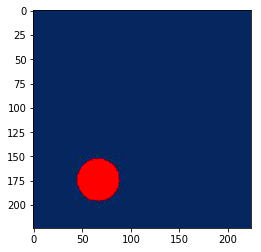

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


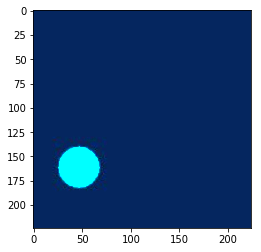

In [58]:
# Visualize cluster content

images = sorted(os.listdir('./Data/Circle_Dataset/train/images/'))

y_kmeans = k_means.predict(output)
ix = np.isin(y_kmeans, 3)
mask = np.where(ix)

for i, (image, label) in enumerate(tqdm(dataloaders['train'])):
    out = torchvision.utils.make_grid(image)
    
    if(i in list(mask[0])):
        out =  np.swapaxes(np.swapaxes(out,0,1),1,2)
        plt.imshow(out)
        plt.show() 
    

# Test with missing image or caption

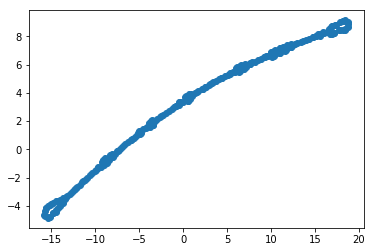

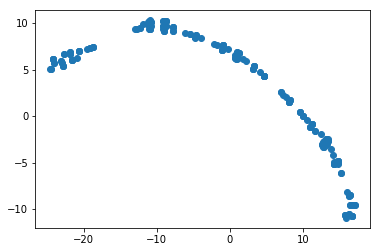

730.4541268273006 250
339.8551301285831 250


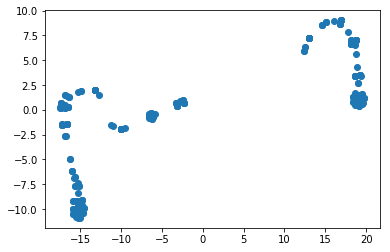

In [25]:
# concatenate and normalize data
dataset_test = normalize_sample(torch.cat((torch.zeros(images_test.shape), captions_test), 1), min_list, max_list)

encoded_test = get_encoded_values(dataset_test)

# get embedding
x_embedded = TSNE(n_components=2).fit_transform(encoded_test)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

discrete_encoded_test = discretize(encoded_test, percentiles, nb_intervals)

# get embedding
x_embedded = TSNE(n_components=2).fit_transform(discrete_encoded_test)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

output_test = recall(discrete_encoded_test)

# get embedding
x_embedded = TSNE(n_components=2).fit_transform(output_test)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

y_kmeans_test = k_means.predict(output_test)
ix = np.isin(y_kmeans_test, 0)
mask = np.where(ix)

for i, (image, label) in enumerate(tqdm(dataloaders['test'])):
    out = torchvision.utils.make_grid(image)
    
    if(i in list(mask[0])):
        out =  np.swapaxes(np.swapaxes(out,0,1),1,2)
        plt.imshow(out)
        plt.axis('off')
        plt.show() 

In [26]:
ix = np.isin(y_kmeans_test, 7)
mask = np.where(ix)

for i, (image, label) in enumerate(tqdm(dataloaders['test'])):
    if(i in list(mask[0])):
        print(label) 